In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers.wrappers import TimeDistributed
from keras.layers.advanced_activations import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline  

In [3]:
def lag_data(data, lag=1):
    data = list(data)
    X, y = [], []
    for i in range(len(data) - lag - 1):
        a = data[i: i + lag]
        X.append(a)
        y.append(data[i + lag])
    return np.array(X), np.array(y)

In [248]:
def create_simple_network(lags):
    model = Sequential()
    model.add(LSTM(56, batch_input_shape=(1, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, activation='softplus'))
    model.add(LSTM(56, batch_input_shape=(1, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, activation='softplus'))
    model.add(LSTM(56, batch_input_shape=(1, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, activation='softplus'))
    model.add(LSTM(14, batch_input_shape=(1, lags, 1), activation='softplus'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_percentage_error', optimizer='adamax')
    return model

In [264]:
def create_simple_network_retain_state(lags, batch_size):
    model = Sequential()
    model.add(LSTM(56, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, activation='softplus', stateful=True))
    model.add(LSTM(56, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, activation='softplus', stateful=True))
    model.add(LSTM(56, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, activation='softplus', stateful=True))
    model.add(LSTM(14, batch_input_shape=(batch_size, lags, 1), activation='softplus', stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    return model

In [124]:
lags = 28
output = 7

# Arrivals

In [23]:
arr = pd.read_csv("../data/Sample/333_arrivals.csv", header=None)[1]
arr.head()

0     2
1    21
2    13
3     5
4     7
Name: 1, dtype: int64

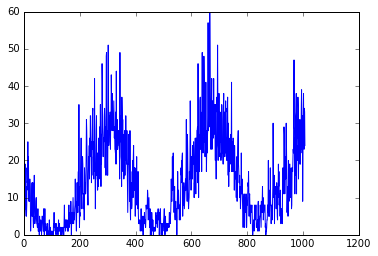

In [24]:
plt.plot(arr)
plt.show()

# 1-Step Forecast

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.read_csv("../data/Sample/333_arrivals.csv", header=None)[1]
data = scaler.fit_transform(data)
train, test = train_test_split(data, test_size=0.30)
X_train, y_train = lag_data(train, lag=lags)
X_test, y_test = lag_data(test, lag=lags)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# model = create_simple_network(lags)
# model.fit(X_train, y_train, nb_epoch=100, batch_size=14, verbose=0)

batch_size = 6
model = create_simple_network_retain_state(lags, batch_size)

for i in range(100):
    model.fit(X_train, y_train, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()


In [263]:
train_preds = model.predict(X_train, batch_size=batch_size)
test_preds = model.predict(X_test, batch_size=batch_size)

train_preds = scaler.inverse_transform(train_preds)
y_train = scaler.inverse_transform(y_train)
test_preds = scaler.inverse_transform(test_preds)
y_test = scaler.inverse_transform(y_test)

train_score = math.sqrt(mean_squared_error(y_train, train_preds))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test, test_preds))
print('Test Score: %.2f RMSE' % (test_score))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [253]:
results = pd.concat([pd.Series(y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]

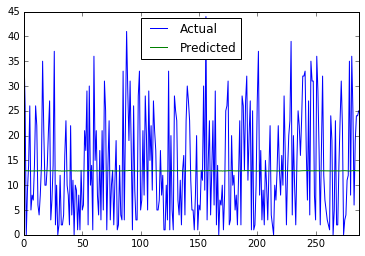

In [254]:
results.plot()

In [245]:
results.head()

,Actual,Predicted
0,6.0,-1.990352
1,28.0,-1.990125
2,3.0,-1.951718
3,11.0,-2.009359
4,21.0,-1.968222


# Departures

In [120]:
dep = pd.read_csv("../data/Sample/333_departures.csv", header=None)[1]
dep.head()

0     3
1    18
2     6
3     6
4     9
Name: 1, dtype: int64

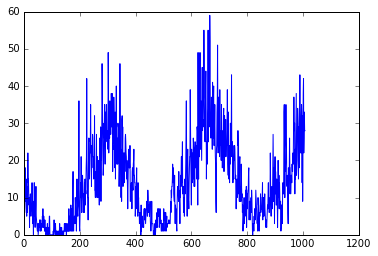

In [121]:
plt.plot(dep)
plt.show()

In [126]:
scaler = MinMaxScaler(feature_range=(0, 1))
model = create_simple_network(lags)
data = pd.read_csv("../data/Sample/333_departures.csv", header=None)[1]
data = scaler.fit_transform(data)
train, test = train_test_split(data, test_size=0.30)
X_train, y_train = lag_data(train, lag=lags)
X_test, y_test = lag_data(test, lag=lags)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model.fit(X_train, y_train, nb_epoch=100, batch_size=128, verbose=0)
train_preds = model.predict(X_train)

/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [127]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_preds = scaler.inverse_transform(train_preds)
y_train = scaler.inverse_transform(y_train)
test_preds = scaler.inverse_transform(test_preds)
y_test = scaler.inverse_transform(y_test)

train_score = math.sqrt(mean_squared_error(y_train, train_preds))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test, test_preds))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 11.04 RMSE
Test Score: 11.37 RMSE


/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
